In [1]:
import time
import emcee
import getdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad, odeint
from getdist import plots, MCSamples
%matplotlib inline

In [2]:
IDL = emcee.backends.HDFBackend("../Chains/IDL=HFSN+2DBAO+CC/LambdaCDM.h5",
                                read_only=True)
tau = IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainIDL = IDL.get_chain(discard=burnin, flat=True, thin=thin)[:, :2]

flatchainIDL_Omegam = IDL.get_chain(discard=burnin, flat=True, thin=thin)[:, 3]

params = tuple(['H_0', 'M_B'])
IDL = MCSamples(samples=flatchainIDL, names=params, labels=params)

Removed no burn in


In [3]:
MB_IDL = emcee.backends.HDFBackend("../Chains/MB(IDL)+LocalSN/LambdaCDM.h5",
                                   read_only=True)
tau = MB_IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainMB_IDL = MB_IDL.get_chain(discard=burnin, flat=True, thin=thin)[:, :2]

params = tuple(['H_0', 'M_B'])
MB_IDL = MCSamples(samples=flatchainMB_IDL, names=params, labels=params)

Removed no burn in


In [4]:
MB_SH0ES_HFSN = emcee.backends.HDFBackend(
    "../Chains/MB(SH0ES)+HFSN/LambdaCDM.h5", read_only=True)
tau = MB_SH0ES_HFSN.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainMB_SH0ES_HFSN = MB_SH0ES_HFSN.get_chain(discard=burnin,
                                                 flat=True,
                                                 thin=thin)[:, :2]

params = tuple(['H_0', 'M_B'])
MB_SH0ES_HFSN = MCSamples(samples=flatchainMB_SH0ES_HFSN,
                          names=params,
                          labels=params)

Removed no burn in


In [5]:
MB_SH0ES_localSN = emcee.backends.HDFBackend(
    "../Chains/MB(SH0ES)+LocalSN/LambdaCDM.h5", read_only=True)
tau = MB_SH0ES_localSN.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainMB_SH0ES_localSN = MB_SH0ES_localSN.get_chain(discard=burnin,
                                                       flat=True,
                                                       thin=thin)[:, :2]

params = tuple(['H_0', 'M_B'])
MB_SH0ES_localSN = MCSamples(samples=flatchainMB_SH0ES_localSN,
                             names=params,
                             labels=params)

Removed no burn in


# Here use the cosmological parameter Omega_m from IDL chains to inversely calibrate local SN, firstly obtain the aB (use Eq.7 in our paper) and then infer H_0 (use Eq.6)

In [6]:
# read the SN data

Pantheonplus_Data = pd.read_csv("../Data/Pantheon+SH0ES.dat", sep='\s+')

Pantheonplus_Data = Pantheonplus_Data[["CID", "zHD", "zCMB", "zHEL", "m_b_corr", 
                                                                     "CEPH_DIST", "IS_CALIBRATOR",
                                                                     "USED_IN_SH0ES_HF"]]

Pantheonplus_covariance = pd.read_csv("../Data/Pantheon+SH0ES_STAT+SYS.cov",
                                                                  sep='\s+').values.reshape(1701, 1701)

local_SN = Pantheonplus_Data.query("zHD<0.0233")

ndim = local_SN.shape[0]
SN_cov = np.zeros((ndim, ndim))
SN_cov_index = local_SN.index
SN_cov = np.array([Pantheonplus_covariance[SN_cov_index[i], SN_cov_index[j]]
                                for i in range(0, ndim) for j in range(0, ndim)
                                ]).reshape(ndim, ndim)

inverse_SN_cov = np.matrix(SN_cov).I


class LCDM(object):

    c = 2.998e5  #  km/s

    def __init__(self, Omegam=None):
        self.Omegam = Omegam
        self.OmegaL = 1 - Omegam

    def Hofz(self, z):
        return np.sqrt(self.OmegaL + self.Omegam * (1 + z)**3)

    def Comoving_distance(self, zcmb):

        dchibydz = lambda z: 1 / self.Hofz(z)

        if ((type(zcmb) == np.ndarray)
                | (type(zcmb) == pd.core.series.Series)):

            I = np.array([quad(dchibydz, 0, nz)[0] for nz in zcmb])
        else:
            I = quad(dchibydz, 0, zcmb)[0]

        res = I
        return res

    def dL(self, zcmb):
        return (1 + zcmb) * self.Comoving_distance(zcmb)

    def calc_aB(self, SN_z_data, inver_cov):

        dL_vector = np.matrix(
            [np.log10(self.dL(zn)) for zn in SN_z_data["zHD"].values])

        mB_vector = np.matrix(0.2 * SN_z_data["m_b_corr"].values)

        delta_vector = dL_vector - mB_vector

        aB = np.sum(inver_cov * delta_vector.T) / np.sum(inver_cov)

        return aB


"""
Here is inverse calibration chain, only need to run once
"""

# aB_Omegam_IDL = np.array([LCDM(Om).calc_aB(local_SN, inverse_SN_cov) for Om in tqdm(flatchainIDL_Omegam)])
# np.save("../Figure3/aB_Omegam_IDL.npy", aB_Omegam_IDL)

100%|██████████████████████████████████████████████████████████████████████████████| 4584/4584 [00:37<00:00, 120.80it/s]


In [7]:
H0_Omegam_IDL = 10**(
    (5 * aB_Omegam_IDL + flatchainIDL[:, 1] + 25) / 5) * 2.998e5

MB_Omegam_IDL_samples = np.array([H0_Omegam_IDL, flatchainIDL[:, 1]]).T

params = tuple(['H_0', 'M_B'])
MB_Omegam_IDL = MCSamples(samples=MB_Omegam_IDL_samples,
                          names=params,
                          labels=params)

Removed no burn in


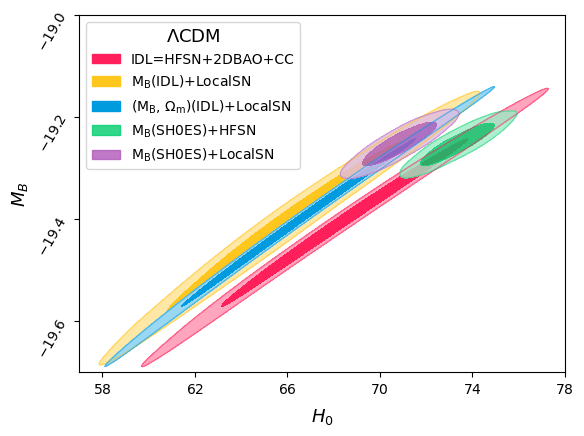

In [8]:
H0 = np.linspace(54, 94, 50)

g = plots.get_single_plotter(width_inch=6, )
g.settings.legend_fontsize = 10
g.settings.num_plot_contours = 2

g.plot_2d([IDL, MB_IDL, MB_Omegam_IDL, MB_SH0ES_HFSN, MB_SH0ES_localSN],
          ['H_0', 'M_B'],
          filled=True,
          colors=[
              '#FF1F5B',
              '#FFC61E',
              '#009ADE',
              '#00CD6C',
              '#AF58BA',
          ],
          lims=[57, 78, -19.7, -19.0],
          alphas=[1, 1, 1, 0.8, 0.8])
plt.xticks(np.arange(54, 94, 4), fontsize=10)
plt.yticks(fontsize=10, rotation=60)
plt.xlim(57, 78)
plt.xlabel("$H_0$", fontsize=13)
plt.ylabel("$M_B$", fontsize=13)

g.add_legend([
    'IDL=HFSN+2DBAO+CC', r'$\mathrm{M_B}$(IDL)+LocalSN',
    r'($\mathrm{M_B}$, $\mathrm{\Omega_m}$)(IDL)+LocalSN',
    r'$\mathrm{M_B}$(SH0ES)+HFSN', r'$\mathrm{M_B}$(SH0ES)+LocalSN'
],
             legend_loc='upper left',
             title="$\Lambda$CDM",
             fontsize=10,
             title_fontsize=13,
             legend_ncol=1)

plt.savefig("LCDM-2D-MB-H0-contour.pdf", dpi=1000, bbox_inches='tight')